# Notebook for the analysis and creation of plots and tables for the report

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load results.csv 

- Tables for delta sarc ratio with confidence intervals and marginals. 
- The same table but just for up and down results.
- Something with the flip rate 
- Plots: 
  - Heatmap input to second round. Let's make it according to claims. 
  - Label distribution: Adjust so that we can see the small percentage. 
  - Valid-output distribution for both rounds. 

### Helper functions

In [2]:
def ci95(x):
    '''
    Helper function to return the 95% Confidence Interval around the mean. 
    '''
    n = x.count()
    if n <= 1:
        return np.nan
    se = x.std(ddof=1) / np.sqrt(n)
    return 1.96 * se

In [3]:
def fmt(m, c):
    if pd.isna(m) or pd.isna(c):
        return "NaN"
    return f"{m:.3f} ± {c:.3f}"

# Sarcasm Rate tables 

In [5]:
results = pd.read_csv('results/results.csv')

In [6]:
print(results.head())

   id model_receiver    model_sender  valid_json_count_r2  round2_sarc_ratio  \
0   1   llama-3.2-3b  mistral-0.2-7b                   10                1.0   
1   3   llama-3.2-3b  mistral-0.2-7b                   10                0.8   
2  32   llama-3.2-3b  mistral-0.2-7b                   10                1.0   
3  33   llama-3.2-3b  mistral-0.2-7b                   10                0.5   
4  38   llama-3.2-3b  mistral-0.2-7b                   10                0.3   

   round1_sarc_ratio  delta_sarc flip_direction  flip  
0                1.0         0.0           none     0  
1                1.0        -0.2           none     0  
2                1.0         0.0           none     0  
3                0.9        -0.4           none     0  
4                0.9        -0.6           down     1  


In [ ]:
def make_delta_table(df, filter = None):
    columns = ['delta_sarc', 'model_receiver', 'model_sender']

    for c in columns:
        if c not in df.columns:
            raise ValueError(f'Missing required column: {c}')
    
    if filter is None:
        df_filter = df[columns].copy()
    elif filter == 'up':
        df_filter = df[df['round1_sarc_ratio'] < 0.5].copy()
        df_filter = df_filter[columns].copy()
    elif filter == 'down':
        df_filter = df[df['round1_sarc_ratio'] >= 0.5].copy()
        df_filter = df_filter[columns].copy()
    else:
        raise ValueError('Filter not defined')
    
    df_filter['abs_delta_sarc'] = df_filter['delta_sarc'].abs()
    df_filter.drop('delta_sarc', inplace = True, axis = 1)

    df_sender_receiver = (df_filter.groupby(['model_receiver', 'model_sender'])['abs_delta_sarc'].agg(mean = 'mean', count = 'count', ci95=ci95).reset_index())
    # print(df_sender_receiver)
    
    pivot_mean = df_sender_receiver.pivot(
        index='model_sender',
        columns = 'model_receiver',
        values = 'mean'
    ).round(2)
    
    pivot_ci = df_sender_receiver.pivot(
        index='model_sender',
        columns='model_receiver',
        values='ci95',
    ).round(3)

    # Add a row label column
    mean_labeled = pivot_mean.copy()
    mean_labeled.index = mean_labeled.index + "_A_mean"

    ci_labeled = pivot_ci.copy()
    ci_labeled.index = ci_labeled.index + "_ci95"

    combined = (
        pd.concat([mean_labeled, ci_labeled], axis=0).sort_index(kind='merge')
    )

    macro_avg_sender = mean_labeled.mean(axis=1, skipna=True)
    macro_avg_receiver = mean_labeled.mean(axis=0, skipna=True)


    combined['avg'] = macro_avg_sender
    combined.loc['avg'] = macro_avg_receiver

    return combined

In [165]:
def make_latex_body(combined, float_fmt="{:.6f}"):
    df = combined.copy()

    base_models = []
    for idx in df.index:
        if idx.endswith("_A_mean"):
            base = idx[:-len("_A_mean")]
        elif idx.endswith("_ci95"):
            base = idx[:-len("_ci95")]
        else:
            continue
        if base not in base_models:
            base_models.append(base)

    def format_row(label, values):
        cells = []
        for v in values:
            if pd.isna(v):
                cells.append("--")
            else:
                cells.append(float_fmt.format(v))
        return "\\texttt{" + label + '}' + "&" + " & ".join(cells) + r" \\"
    
    def format_row_ci(label, values):
        cells = []
        for v in values[:-1]:
            if pd.isna(v):
                cells.append("")
            elif label in ('marg', 'avg'):
                cells.append("")
            else:
                v = '('+ u"\u00B1" + float_fmt.format(v) + ')'
                v = "\\footnotesize{" + v + "}"
                cells.append(v)
        cells.append('')

        row = f" & " + " & ".join(cells) + r" \\"
        return row

    header = list(base_models) + ['Avg.']
    header_tex = ["\\texttt{" + h + "}" for h in header]
    header_str = " & " + " & ".join(header_tex) + r" \\" + '\n' + '\\midrule'
    lines = [header_str]
    base_models.append('avg')

    for base in base_models:
        if base != 'avg':
            ci_idx = base + "_ci95"
            mean_idx = base + "_A_mean"
            ci_vals = df.loc[ci_idx].values
            mean_vals = df.loc[mean_idx].values
        else:
            lines.append('\\midrule')
            mean_idx = 'avg'
            mean_vals = df.loc[mean_idx].values
            ci_vals = df.loc[ci_idx].values
    

        lines.append(format_row(base, mean_vals))
        lines.append(format_row_ci(base, ci_vals))
    lines.pop()

    return "\n".join(lines)


In [166]:
df_table = make_delta_table(results)

    model_receiver    model_sender      mean  count      ci95
0     llama-3.2-3b  mistral-0.2-7b  0.206452  10445  0.005433
1     llama-3.2-3b  mistral-0.3-7b  0.886565   2448  0.006541
2     llama-3.2-3b   qwen-2.5-1.5b  0.048191  75796  0.000898
3     llama-3.2-3b     qwen-2.5-7b  0.347259   5294  0.010766
4   mistral-0.2-7b    llama-3.2-3b  0.891995  10445  0.003471
5   mistral-0.2-7b  mistral-0.3-7b  0.915113  13669  0.003129
6   mistral-0.2-7b   qwen-2.5-1.5b  0.371561  69725  0.003144
7   mistral-0.2-7b     qwen-2.5-7b  0.868438  12042  0.004675
8   mistral-0.3-7b    llama-3.2-3b  0.246410   2448  0.012187
9   mistral-0.3-7b  mistral-0.2-7b  0.178579  13669  0.004498
10  mistral-0.3-7b   qwen-2.5-1.5b  0.061278  83281  0.001231
11  mistral-0.3-7b     qwen-2.5-7b  0.204065   5529  0.008270
12   qwen-2.5-1.5b    llama-3.2-3b  0.957035  75796  0.000575
13   qwen-2.5-1.5b  mistral-0.2-7b  0.972347  69725  0.000483
14   qwen-2.5-1.5b  mistral-0.3-7b  0.974908  83281  0.000431
15   qwe

In [163]:
df_table

model_receiver,llama-3.2-3b,mistral-0.2-7b,mistral-0.3-7b,qwen-2.5-1.5b,qwen-2.5-7b,avg
model_sender,,,,,,
llama-3.2-3b_A_mean,NaN,0.8900,0.2500,0.9600,0.700,0.7000
llama-3.2-3b_ci95,NaN,0.0030,0.0120,0.0010,0.010,NaN
mistral-0.2-7b_A_mean,0.210,NaN,0.1800,0.9700,0.350,0.4275
mistral-0.2-7b_ci95,0.005,NaN,0.0040,0.0000,0.007,NaN
mistral-0.3-7b_A_mean,0.890,0.9200,NaN,0.9700,0.950,0.9325
mistral-0.3-7b_ci95,0.007,0.0030,NaN,0.0000,0.004,NaN
qwen-2.5-1.5b_A_mean,0.050,0.3700,0.0600,NaN,0.080,0.1400
qwen-2.5-1.5b_ci95,0.001,0.0030,0.0010,NaN,0.001,NaN
qwen-2.5-7b_A_mean,0.350,0.8700,0.2000,0.9700,NaN,0.5975


In [16]:
print(make_latex_body(df_table, float_fmt="{:.2f}"))

 & \texttt{llama-3.2-3b} & \texttt{mistral-0.2-7b} & \texttt{mistral-0.3-7b} & \texttt{qwen-2.5-1.5b} & \texttt{qwen-2.5-7b} & \texttt{Avg.} \\
\midrule
\texttt{llama-3.2-3b}&-- & 0.89 & 0.25 & 0.96 & 0.70 & 0.70 \\
 &  & \footnotesize{(±0.00)} & \footnotesize{(±0.01)} & \footnotesize{(±0.00)} & \footnotesize{(±0.01)} &  \\
\texttt{mistral-0.2-7b}&0.21 & -- & 0.18 & 0.97 & 0.35 & 0.43 \\
 & \footnotesize{(±0.01)} &  & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} & \footnotesize{(±0.01)} &  \\
\texttt{mistral-0.3-7b}&0.89 & 0.92 & -- & 0.97 & 0.95 & 0.93 \\
 & \footnotesize{(±0.01)} & \footnotesize{(±0.00)} &  & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  \\
\texttt{qwen-2.5-1.5b}&0.05 & 0.37 & 0.06 & -- & 0.08 & 0.14 \\
 & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  & \footnotesize{(±0.00)} &  \\
\texttt{qwen-2.5-7b}&0.35 & 0.87 & 0.20 & 0.97 & -- & 0.60 \\
 & \footnotesize{(±0.01)} & \footnotesize{(±0.01)} & \footnotesize{(±0.01)} & \footnotes

### The same tabel, just split the receiver's initial label from round 1.

In [167]:
up_df = make_delta_table(results, filter='up')
up_df

    model_receiver    model_sender      mean  count      ci95
0     llama-3.2-3b  mistral-0.2-7b  0.906303    758  0.006481
1     llama-3.2-3b  mistral-0.3-7b  0.910195   2365  0.003997
2     llama-3.2-3b     qwen-2.5-7b  0.907090   1586  0.004926
3   mistral-0.2-7b    llama-3.2-3b  0.906955   9687  0.003065
4   mistral-0.2-7b  mistral-0.3-7b  0.915148  13664  0.003129
5   mistral-0.2-7b   qwen-2.5-1.5b  0.835433    127  0.023347
6   mistral-0.2-7b     qwen-2.5-7b  0.903925  10005  0.004082
7   mistral-0.3-7b    llama-3.2-3b  0.886747     83  0.022978
8   mistral-0.3-7b  mistral-0.2-7b  0.980000      5  0.039200
9   mistral-0.3-7b     qwen-2.5-7b  0.912371     97  0.018892
10   qwen-2.5-1.5b    llama-3.2-3b  0.957035  75796  0.000575
11   qwen-2.5-1.5b  mistral-0.2-7b  0.972517  69598  0.000482
12   qwen-2.5-1.5b  mistral-0.3-7b  0.974908  83281  0.000431
13   qwen-2.5-1.5b     qwen-2.5-7b  0.973549  77398  0.000465
14     qwen-2.5-7b    llama-3.2-3b  0.932000   3707  0.004166
15     q

model_receiver,llama-3.2-3b,mistral-0.2-7b,mistral-0.3-7b,qwen-2.5-1.5b,qwen-2.5-7b,avg
model_sender,,,,,,
llama-3.2-3b_A_mean,NaN,0.9100,0.890000,0.9600,0.9300,0.9225
llama-3.2-3b_ci95,NaN,0.0030,0.023000,0.0010,0.0040,NaN
mistral-0.2-7b_A_mean,0.910,NaN,0.980000,0.9700,0.9700,0.9575
mistral-0.2-7b_ci95,0.006,NaN,0.039000,0.0000,0.0040,NaN
mistral-0.3-7b_A_mean,0.910,0.9200,NaN,0.9700,0.9600,0.9400
mistral-0.3-7b_ci95,0.004,0.0030,NaN,0.0000,0.0030,NaN
qwen-2.5-1.5b_A_mean,NaN,0.8400,NaN,NaN,0.9300,0.8850
qwen-2.5-1.5b_ci95,NaN,0.0230,NaN,NaN,0.0280,NaN
qwen-2.5-7b_A_mean,0.910,0.9000,0.910000,0.9700,NaN,0.9225


In [18]:
down_df = make_delta_table(results, filter='down')
down_df

model_receiver,llama-3.2-3b,mistral-0.2-7b,mistral-0.3-7b,qwen-2.5-1.5b,qwen-2.5-7b,avg
model_sender,,,,,,
llama-3.2-3b_A_mean,NaN,0.700,0.2200,NaN,0.1700,0.363333
llama-3.2-3b_ci95,NaN,0.024,0.0120,NaN,0.0110,NaN
mistral-0.2-7b_A_mean,0.150,NaN,0.1800,0.880,0.2300,0.360000
mistral-0.2-7b_ci95,0.004,NaN,0.0040,0.019,0.0060,NaN
mistral-0.3-7b_A_mean,0.210,0.820,NaN,NaN,0.3500,0.460000
mistral-0.3-7b_ci95,0.050,0.218,NaN,NaN,0.0600,NaN
qwen-2.5-1.5b_A_mean,0.050,0.370,0.0600,NaN,0.0800,0.140000
qwen-2.5-1.5b_ci95,0.001,0.003,0.0010,NaN,0.0010,NaN
qwen-2.5-7b_A_mean,0.110,0.690,0.1900,0.890,NaN,0.470000


In [19]:
print(make_latex_body(up_df, float_fmt="{:.2f}"))

 & \texttt{llama-3.2-3b} & \texttt{mistral-0.2-7b} & \texttt{mistral-0.3-7b} & \texttt{qwen-2.5-1.5b} & \texttt{qwen-2.5-7b} & \texttt{Avg.} \\
\midrule
\texttt{llama-3.2-3b}&-- & 0.91 & 0.89 & 0.96 & 0.93 & 0.92 \\
 &  & \footnotesize{(±0.00)} & \footnotesize{(±0.02)} & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  \\
\texttt{mistral-0.2-7b}&0.91 & -- & 0.98 & 0.97 & 0.97 & 0.96 \\
 & \footnotesize{(±0.01)} &  & \footnotesize{(±0.04)} & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  \\
\texttt{mistral-0.3-7b}&0.91 & 0.92 & -- & 0.97 & 0.96 & 0.94 \\
 & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  \\
\texttt{qwen-2.5-1.5b}&-- & 0.84 & -- & -- & 0.93 & 0.89 \\
 &  & \footnotesize{(±0.02)} &  &  & \footnotesize{(±0.03)} &  \\
\texttt{qwen-2.5-7b}&0.91 & 0.90 & 0.91 & 0.97 & -- & 0.92 \\
 & \footnotesize{(±0.01)} & \footnotesize{(±0.00)} & \footnotesize{(±0.02)} & \footnotesize{(±0.00)} &  &  \\
\midrule
\texttt{avg}&0.91

In [20]:
print(make_latex_body(down_df, float_fmt="{:.2f}"))

 & \texttt{llama-3.2-3b} & \texttt{mistral-0.2-7b} & \texttt{mistral-0.3-7b} & \texttt{qwen-2.5-1.5b} & \texttt{qwen-2.5-7b} & \texttt{Avg.} \\
\midrule
\texttt{llama-3.2-3b}&-- & 0.70 & 0.22 & -- & 0.17 & 0.36 \\
 &  & \footnotesize{(±0.02)} & \footnotesize{(±0.01)} &  & \footnotesize{(±0.01)} &  \\
\texttt{mistral-0.2-7b}&0.15 & -- & 0.18 & 0.88 & 0.23 & 0.36 \\
 & \footnotesize{(±0.00)} &  & \footnotesize{(±0.00)} & \footnotesize{(±0.02)} & \footnotesize{(±0.01)} &  \\
\texttt{mistral-0.3-7b}&0.21 & 0.82 & -- & -- & 0.35 & 0.46 \\
 & \footnotesize{(±0.05)} & \footnotesize{(±0.22)} &  &  & \footnotesize{(±0.06)} &  \\
\texttt{qwen-2.5-1.5b}&0.05 & 0.37 & 0.06 & -- & 0.08 & 0.14 \\
 & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} & \footnotesize{(±0.00)} &  & \footnotesize{(±0.00)} &  \\
\texttt{qwen-2.5-7b}&0.11 & 0.69 & 0.19 & 0.89 & -- & 0.47 \\
 & \footnotesize{(±0.01)} & \footnotesize{(±0.02)} & \footnotesize{(±0.01)} & \footnotesize{(±0.02)} &  &  \\
\midrule
\texttt{avg}&0.13

# Majority label distribution: Round 1 

Note: The majority label for a model on a given claim is the label for which the model in the $C$ repetitions has predicted to majority of times. 

In [21]:
def majority_label_table(df):
    df = df.copy()
    df['label'] = df['sarc_ratio'].apply(
        lambda x: 'sarcastic' if x >= 0.5 else 'literal'
    )
    df['label'] = df['label'].astype(
        pd.CategoricalDtype(categories=['sarcastic', 'literal'])
    )
    counts = df.groupby(['model', 'label'], observed=False).size().reset_index(name='count')

    counts['value'] = ((counts['count'] / counts.groupby('model')['count'].transform('sum')) * 100)

    counts_sarc = counts[counts['label'] == 'sarcastic'][['model', 'value']]
    counts_sarc.set_index('model', inplace = True)
    counts_sarc.rename(columns = {'value': 'Sarcastic %'}, inplace = True)
    return counts_sarc

In [22]:
df = pd.read_csv('results/first-results-sarc-ratio.csv')

In [23]:
df_majority_label = majority_label_table(df)
print(df_majority_label.to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
 & Sarcastic % \\
model &  \\
\midrule
llama-3.2-1b & 100.00 \\
llama-3.2-3b & 96.85 \\
mistral-0.2-7b & 89.17 \\
mistral-0.3-7b & 99.63 \\
qwen-2.5-1.5b & 28.11 \\
qwen-2.5-7b & 95.30 \\
\bottomrule
\end{tabular}



# Plots 

In [1]:
heatmap_df = pd.read_csv('results/input-r2-claim-count.csv')

NameError: name 'pd' is not defined

In [38]:
print(heatmap_df.head())
print(heatmap_df.columns)

   model_sender model_receiver label_receiver_agg  id  count
0  llama-3.2-3b    qwen-2.5-7b            literal  13     10
1  llama-3.2-3b    qwen-2.5-7b            literal  18     10
2  llama-3.2-3b    qwen-2.5-7b            literal  33     10
3  llama-3.2-3b    qwen-2.5-7b            literal  38     10
4  llama-3.2-3b    qwen-2.5-7b            literal  73     10
Index(['model_sender', 'model_receiver', 'label_receiver_agg', 'id', 'count'], dtype='object')


In [ ]:
def make_matrix(df, label, models):
    # return a matrix for label. The label given here is the label, we want to be the starting label for the receiver model. 
    subset = df[df['label_receiver_agg'] == label].copy() #because we want the receiver model label, not the sender. 
    mat = (
        subset
        .pivot(index='model_sender',
               columns = 'model_receiver',
               values = 'n_unique_claims')
        .reindex(index=models, columns = models)
        .fillna(0)
    )

    return mat


In [ ]:
models = sorted(set(heatmap_df['model_sender']) | set(heatmap_df['model_receiver']))
mat_lit = make_matrix(heatmap_df, 'literal', models)
mat_sarc = make_matrix(heatmap_df, 'sarcastic', models)


In [49]:
sns.set_style('white')

# Shared colour limits 
vmin = min(mat_lit.to_numpy().min(), mat_sarc.to_numpy().min())
vmax = max(mat_lit.to_numpy().max(), mat_sarc.to_numpy().max())


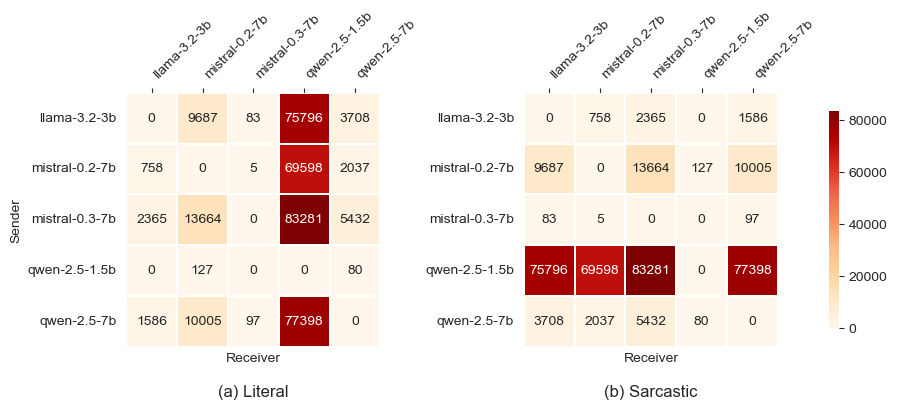

In [ ]:
f,(ax1,ax2, axcb) = plt.subplots(1,3,
                                figsize = (10, 6),
                                gridspec_kw={'width_ratios':[1,1,0.04]})

g1 = sns.heatmap(
    mat_lit, 
    ax=ax1,
    cmap='OrRd',
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt='g',
    cbar=False,
    square=True,
    linewidths=0.1,
    linecolor='white'
)

g2 = sns.heatmap(
    mat_sarc, 
    ax=ax2,
    cmap='OrRd',
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt='g',
    cbar=True,
    cbar_ax=axcb,
    square=True,
    linewidths=0.1,
    linecolor='white',
)

g2.set_ylabel("")
# g2.set_yticklabels([])

for ax in [g1, g2]:
    ax.set_xlabel("Receiver")
    if ax == g1:
        ax.set_ylabel("Sender")
        ax.set_title('(a) Literal', y = -0.23)
    else:
        ax.set_title('(b) Sarcastic', y = -0.23)
    # put x ticks & label on top
    ax.xaxis.tick_top()

    plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'left', va = 'bottom', rotation_mode='default')
    ax.tick_params(axis='x', pad=5)
    # ax.tick_params(axis="x", rotation=45)


plt.tight_layout()

pos = axcb.get_position()
axcb.set_position([
    pos.x0 * 0.9,
    pos.y0 + pos.height * 0.3,
    pos.width,
    pos.height * 0.4
])

plt.savefig('plots/heatmap-claim-count-r2-input.png', bbox_inches='tight',dpi=300)
plt.show()

# True label distribution

In [ ]:
# filtered on length of sentence
sarc = pd.read_csv('data/sarc/sarcasm.csv')

#filtered datset
sarc_filtered = pd.read_csv('data/sarc/sarcasm2.csv')


print(f'Size of the original dataset is: {sarc.shape[0]}')
print(f'True label distribution of original is: {sarc['label'].value_counts()}')

print(f'Size of the filtered dataset is: {sarc_filtered.shape[0]}')
print(f'True label distribution of filtered is: {sarc_filtered['label'].value_counts()}')

Size of the original dataset is: 146215
True label distribution of original is: label
sarcastic    76158
literal      70057
Name: count, dtype: int64
Size of the filtered dataset is: 137454
True label distribution of filtered is: label
sarcastic    71103
literal      66351
Name: count, dtype: int64


In [10]:
66351/137454

0.4827142171199092

In [8]:
flagged = pd.read_csv('data/sarc/flagged2.csv')
flagged.shape[0]

8761